In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
data = pd.read_csv('FFChallenge/background.csv')
outcomes = pd.read_csv('FFChallenge/train.csv')

/Users/aarshay/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10025,10029,10032,10575,10578,10592,10607,10616,10631,10640,10655,10693,10712,10716,10740,10782,10787,10791,10796,10833,10865,10999,11030,11043,11127,11128,11234,11258,11282,11309,11310,11384,11394,11408,11409,11411,11412,11438,11441,11485,11490,11504,11508,11511,11514,11520,11527,11533,11539,11545,11546,11624,11629,11658,11672,11673,11678,11679,11680,11719,11721,11934,12160,12166,12168,12177,12183,12189,12199,12201,12203,12205,12216,12217,12228,12229,12239,12300,12316,12358,12367,12375,12402,12404,12408,12451,12453,12465,12467,12475,12481,12483,12496,12498,12520,12530,12531,12541,12599,12607,12623,12638,12650,12651,12663,12668,12715,12717,12735,12736,12758,12762,12772,12781,12788,12800,12801) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.shape

(4242, 12943)

In [4]:
outcomes.shape

(2121, 7)

In [5]:
#define the columns required and reduce the dataframe
required_cols = ['challengeID']
required_cols.extend(['cm%dcohp'%i for i in range(2,6)])
required_cols.extend(['cm%dmarp'%i for i in range(2,6)])
required_cols.extend(['m1e1b%d'%i for i in range(1,9)])
required_cols.extend(['cm%dcohf'%i for i in range(1,6)])
required_cols.extend(['m4a13','m5d2h','m4e2h','m2e2','m4c1c','m5a101'])
required_cols.extend(['cm%drelf'%i for i in range(1,6)])
required_cols.extend(['m%dc2'%i for i in range(2,5)]+['m5b2'])
required_cols.extend(['m%dc5'%i for i in range(2,5)]+['m5b3'])
required_cols.extend(['cm1edu','cf1edu','cm5md_case_con','cm5md_case_lib',
                      'cm3gad_case','cm3alc_case','cm3drug_case'])
required_cols.extend(['cm%dhhinc'%i for i in range(1,6)])
required_cols.extend(['k5b2d','k5b1d','k5b3d'])

In [6]:
df = data[required_cols]
df.shape

(4242, 56)

In [7]:
df = df.merge(outcomes[['challengeID','gpa','grit']],on='challengeID',how='left')
df.shape

(4242, 58)

## Drop rows

### drop values withouth gpa or grit

In [8]:
df = df.dropna(subset=['gpa','grit'])

In [9]:
df.shape

(1162, 58)

### not in wave
use cohf for mothers not in wave

In [10]:
cols = ['cm%dcohf'%i for i in range(1,6)]
df['num_mothers_not_in_wave'] = df[cols].apply(lambda x: sum(x==-9),axis=1)

In [11]:
df['num_mothers_not_in_wave'].value_counts()

0    951
1    158
2     44
3      7
4      2
Name: num_mothers_not_in_wave, dtype: int64

In [12]:
#drop all:
df.loc[df['num_mothers_not_in_wave']!=0,'num_mothers_not_in_wave']=np.nan
df=df.dropna(subset=['num_mothers_not_in_wave'])
df.shape

(951, 59)

### drop father custody:

In [13]:
df['m4c1c'].value_counts()

 2    503
-6    446
 1      2
Name: m4c1c, dtype: int64

In [14]:
df.loc[df['m4c1c']==1,'m4c1c']=np.nan
df=df.dropna(subset=['m4c1c'])
df.shape

(949, 59)

In [15]:
df.head()

,challengeID,cm2cohp,cm3cohp,cm4cohp,cm5cohp,cm2marp,cm3marp,cm4marp,cm5marp,m1e1b1,...,cm2hhinc,cm3hhinc,cm4hhinc,cm5hhinc,k5b2d,k5b1d,k5b3d,gpa,grit,num_mothers_not_in_wave
6,7,0,0,0,0,0,0,0,0,1,...,62734.484774,52626.128551,50674.811427,78726.236096,0,4,-6,2.50,3.25,0.0
8,9,0,0,0,0,0,0,0,0,3,...,15160.459993,27605.370852,21406.196061,59011.060985,0,0,-6,2.25,4.00,0.0
12,13,0,0,0,0,0,0,0,1,3,...,22649.223008,34357.163395,31259.561175,0.000000,1,1,0,2.75,4.00,0.0
13,14,0,0,0,0,0,0,0,0,3,...,55901.339636,30175.323134,43044.954909,30141.137894,3,1,-6,3.25,2.75,0.0
15,16,0,0,1,0,0,0,0,1,4,...,7840.233692,10355.853114,992.308932,26114.322671,0,2,-6,2.00,3.50,0.0


# Features:

In [16]:
#function for raw features
def view_var(data,x,year=[1,2,3,4],print_counts=False):
    col = []
    for t in x:
        col.extend([i for i in data.columns if t in i])
    print('cols found: %s'%col)
    if not print_counts:
        print(data[col].head(50))
    else:
        for x in col:
#             print('value counts for variable %s'%col)
            print(data[x].value_counts())

In [17]:
def recode_vars(x,code_dict):
    d = {}
    for key,values in code_dict.items():
        for val in values:
            d[val]=key
    
    x2 = x.replace(d)
    assert set(np.unique(x2)) == set(code_dict.keys())
    return x2

In [18]:
df_new = df.copy()

## Father's Involvement:

In [19]:
#dictionary:
code_dict = {
    'full': [1],
    'partial': [2,3],
    'none': [4,5,-2,-6]
}

#cols:
cols = ['m%dc5'%i for i in range(2,5)]+['m5b3']
df_new[cols] = df[cols].apply(lambda x: recode_vars(x,code_dict=code_dict))

In [20]:
#get score:
def involvement(x):
    key = {'full':5, 'partial':2.5, 'none':0}
    weights = [0.1, 0.2, 0.3, 0.4]
    absscore = [key[i] for i in x]
    weighted_score = np.dot(weights,absscore)
    return 'low' if weighted_score<1.75 else 'medium' if weighted_score<3.5 else 'high'

In [21]:
# df_new[cols[1:]].apply(lambda x: ' '.join(x.values),axis=1).value_counts()

In [22]:
df_new['father_involvement'] = df_new[cols].apply(involvement, axis=1)

In [23]:
df_new['father_involvement'].value_counts()

high      386
low       319
medium    244
Name: father_involvement, dtype: int64

In [24]:
#test code
# x=range(0,6)

# for i in x:
#     print(i,'none' if i<2 else 'partial' if i<4 else 'full')

## Father's presence

In [25]:
filter_cols = ['m%dc2'%i for i in range(2,5)]+['m5b2']
relf_cols = ['cm%drelf'%i for i in range(2,6)]
[i for i in zip(filter_cols,relf_cols)]

[('m2c2', 'cm2relf'),
 ('m3c2', 'cm3relf'),
 ('m4c2', 'cm4relf'),
 ('m5b2', 'cm5relf')]

In [26]:
for col in filter_cols:
    print(df[col].value_counts())

-6    575
 1    341
 2     31
-1      2
Name: m2c2, dtype: int64
-6    520
 1    373
 2     53
-2      2
 3      1
Name: m3c2, dtype: int64
-6    446
 1    406
 2     93
 3      3
-2      1
Name: m4c2, dtype: int64
-6    421
 1    379
 2    147
 3      2
Name: m5b2, dtype: int64


m2c2: 0=dont know of child; 1=yes; 2=no; -2: dont know; -1: refused
m3c2/m4c2/m5b2: 3=dont know of child; 1=yes; 2=no; -2: dont know; -1: refused

In [27]:
def father_presence(df,df2,col,var):
    df2[col] = [np.nan]*df2.shape[0]
    print(col)
    df2.loc[[ x in [0,2,3] for x in df[var[0]] ],col] = 'none'
    df2.loc[[x in [1,2] for x in df[var[1]]],col] = 'full'
    df2[col]=df2[col].fillna('partial')
#     print(df2[col])

In [28]:
df_new.shape

(949, 60)

In [29]:
new_cols = ['presence_%d'%i for i in range(2,6)]
for var in zip(filter_cols,relf_cols, new_cols):
    father_presence(df_new,df_new,var[2],var[:-1])

presence_2
presence_3
presence_4
presence_5


In [30]:
for col in new_cols:
    print(df_new[col].value_counts())

full       535
partial    383
none        31
Name: presence_2, dtype: int64
full       482
partial    413
none        54
Name: presence_3, dtype: int64
partial    434
full       420
none        95
Name: presence_4, dtype: int64
partial    425
full       375
none       149
Name: presence_5, dtype: int64


In [31]:
df_new[new_cols].head()

,presence_2,presence_3,presence_4,presence_5
6,full,partial,full,full
8,full,full,full,full
12,full,full,partial,partial
13,full,full,full,full
15,partial,partial,partial,partial


In [32]:
df_new['father_presence'] = df_new[new_cols].apply(involvement, axis=1)

In [33]:
df_new['father_presence'].value_counts()

high      438
medium    379
low       132
Name: father_presence, dtype: int64

In [34]:
# df_new[new_cols].apply(lambda x: ' '.join(x.values),axis=1).value_counts()

## Number of partners
apart from father

In [35]:
cols = ['m4a13','m5a101']
for col in cols:
    print(df_new[col].value_counts())

-6     420
 1     294
 0     130
 2      53
-10     25
 3      14
 4       5
-1       3
-2       2
 5       2
 6       1
Name: m4a13, dtype: int64
-6    482
 1    335
 2    104
 3     20
 4      3
 5      2
-2      1
 7      1
 6      1
Name: m5a101, dtype: int64


-10: only father -> 0
-6: skipped -> 0
-1: refused -> 0
-2: dont know -> 0

In [36]:
code_dict = {
    -6:0, -10:0, -1:0, -2:0
}
df_new['num_partners'] = df_new['m4a13'].replace(code_dict) + df_new['m5a101'].replace(code_dict)

In [37]:
df_new['num_partners'].value_counts()

0    412
2    227
1    180
3     79
4     31
6      9
5      6
7      3
8      2
Name: num_partners, dtype: int64

## Cohabitating with biological father

In [38]:
relf_cols = ['cm%drelf'%i for i in range(2,6)]

In [39]:
df_new['num_cohab_biof'] = df_new[relf_cols].apply( lambda x: sum([i in [1,2] for i in x]) ,axis=1)

In [40]:
df_new['num_cohab_biof'].value_counts()

0    333
4    298
1    122
3    106
2     90
Name: num_cohab_biof, dtype: int64

## Cohbitating with any partner

In [41]:
cols = ['cm%dcohp'%i for i in range(2,6)]+['cm%dmarp'%i for i in range(2,6)]

In [42]:
for col in cols:
    print(df_new[col].value_counts())

 0    905
 1     43
-3      1
Name: cm2cohp, dtype: int64
0    878
1     71
Name: cm3cohp, dtype: int64
0    840
1    109
Name: cm4cohp, dtype: int64
0    820
1    129
Name: cm5cohp, dtype: int64
0    945
1      4
Name: cm2marp, dtype: int64
0    932
1     17
Name: cm3marp, dtype: int64
0    909
1     40
Name: cm4marp, dtype: int64
0    863
1     86
Name: cm5marp, dtype: int64


In [43]:
df_new['cm2cohp']=df_new['cm2cohp'].replace({-3:0})

In [44]:
df_new['num_cohab_anyp'] = df_new['num_cohab_biof'] + df_new[cols].apply( sum ,axis=1 )
df_new['num_cohab_anyp'] = [min(x,4) for x in df_new['num_cohab_anyp']]

In [45]:
df_new['num_cohab_anyp'].value_counts()

4    348
3    161
1    154
0    146
2    140
Name: num_cohab_anyp, dtype: int64

## Control variables:

### education

In [46]:
df_new['cm1edu'].value_counts()

2    303
1    277
3    245
4    124
Name: cm1edu, dtype: int64

1= <high school, 2: highschool; 3: some college/tech; 4: college/grad

In [47]:
df_new['mothers_education'] = df_new['cm1edu']
df_new['fathers_education'] = df_new['cf1edu']

In [56]:
df_new['fathers_education'].value_counts()

 2    336
 1    270
 3    197
 4    115
-3     31
Name: fathers_education, dtype: int64

In [57]:
#impute with 2:
df_new['fathers_education'] = df_new['fathers_education'].replace({-3:2})

### cidi

In [48]:
cols = ['cm5md_case_con','cm5md_case_lib',
                      'cm3gad_case','cm3alc_case','cm3drug_case']
df_new['num_cidi_cases'] = df_new[cols].apply(lambda x: sum(x==1),axis=1)

In [49]:
df_new['num_cidi_cases'].value_counts()

0    764
2    109
1     62
3     13
4      1
Name: num_cidi_cases, dtype: int64

In [50]:
# for col in cols:
#     print(df_new[col].value_counts())

### income:

In [51]:
cols = ['cm%dhhinc'%i for i in range(1,6)]
df_new[cols].describe()

,cm1hhinc,cm2hhinc,cm3hhinc,cm4hhinc,cm5hhinc
count,949.000000,949.000000,949.000000,949.000000,949.000000
mean,34369.173349,32393.883401,34004.734992,35971.773699,43996.135849
std,33967.481081,28561.716310,30280.361359,31298.961049,35754.889301
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9860.334342,10720.318967,10605.645092,12080.658286,17221.713708
50%,24464.342940,23808.365414,24151.659622,27469.927295,33266.234034
75%,45749.527751,47900.920657,49574.607878,51998.298061,60669.658965
max,145833.813461,114441.688881,120349.777647,126188.204789,144650.434307


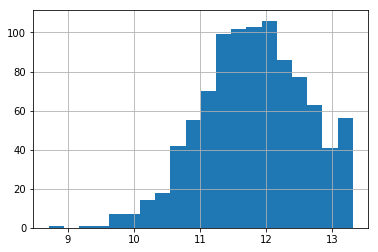

In [52]:
df_new['hh_income'] = df_new[cols].apply(lambda x: np.log(sum(x)+1+1e-10),axis=1)
df_new['hh_income'].hist(bins=20)

### domestic spanking

In [53]:
cols = ['k5b2d','k5b1d','k5b3d']
for col in cols:
    print(df_new[col].value_counts())

 0    451
-6    179
 1    118
 2     80
 3     48
-9     32
 4     25
-1      8
-2      7
-3      1
Name: k5b2d, dtype: int64
 0    435
 1    197
 2    136
 3     81
 4     42
-9     32
-2     11
-1     10
-6      4
-3      1
Name: k5b1d, dtype: int64
-6    747
 0    126
-9     32
 1     21
 3      7
 4      6
 2      4
-2      3
-1      2
-3      1
Name: k5b3d, dtype: int64


In [54]:
code_dict={-6:0, -9:1, -1:1,-2:1,-3:1}
df_new['kid_punished'] = df_new[cols].apply(lambda x: sum(x.replace(code_dict)),axis=1)
df_new['kid_punished'].value_counts()

0     382
2     144
1     133
3     130
4      88
6      28
5      23
8      13
7       6
12      2
Name: kid_punished, dtype: int64

## Final exports:
New features created:

Explanatory:
* father_involvement
* father_presence
* num_partners
* num_cohab_biof
* num_cohab_anyp

Control:
* mothers_education
* fathers_education
* num_cidi_cases
* hh_income
* kid_punished

In [58]:
df_new.to_csv('FFChallenge/final_data.csv',index=False)